In [1]:
#### This code is for ATOC7500 project 4 part II
#import modules
import numpy as np   #for calculations
import matplotlib.pyplot as plt  #for plotting
%matplotlib inline  
import pandas as pd  #for reading in data
import collections  #for additional dictionary functionality
from matplotlib.gridspec import GridSpec #for subplots
import scipy.signal as signal #for signal processing
import scipy.stats as stats

In [2]:
## read in data
filename = 'homework4_data2.csv'
data_file=pd.read_csv(filename,sep=',')
data_file.head()

,SaFra
0,0.804019
1,0.820884
2,0.808491
3,0.846140
4,0.838313


In [3]:
def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)
def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,200) # Note: 200 = large degree of freedom for red noise
    return f_ratio*red_fit_n

In [4]:
## get anomally
data_temp=data_file['SaFra']
data=data_temp-np.mean(data_temp)

## Calculate lag-1 autocorrelation and e-folding time of data
rho,lag1_p = stats.pearsonr(data[0:len(data)-1],data[1:len(data)])
Te = -1./np.log(rho) # After Hartmann 6.4 with delta t = 1
print('autocorrelation=',round(rho,2),'and Te =',round(Te,2),'hours')
print('  ')

autocorrelation= 0.73 and Te = 3.16 hours
  


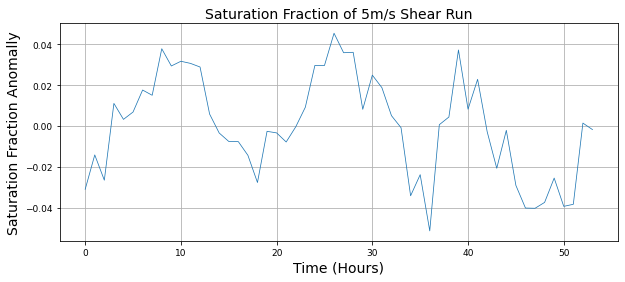

In [5]:
## Plot data
fig = plt.figure(figsize=(10,4))
plt.plot(data, lw=.75)
plt.ylabel('Saturation Fraction Anomally',fontsize=14)
plt.xlabel('Time (Hours)',fontsize=14)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title('Saturation Fraction of 5m/s Shear Run',fontsize=14)
plt.grid()

In [6]:
alpha = 0.99 ## set statistical significance level

##### METHOD #1 - Numpy Method - Calculate FFT
freq = np.fft.rfftfreq(len(data),d=1.)
A = np.fft.rfft(data)    #amplitude
ps = (np.abs(A)**2)/2.   #power spectra = amplitude square/2, Bar's note CH 4 EQ 24
ps_n = (np.abs(A)**2)/np.sum(np.abs(A)**2)   #power spectra percentage, percentage variance explained
Ao = ps[0]
red_fit_n = create_normalized_redfit(len(data),Te)
f_bounds = create_f_bounds(alpha,2*1,red_fit_n)

In [7]:
# Find the significant spectral peaks
for i in range(len(ps_n)):
    if (ps_n[i] - f_bounds[i]) > 1e-03:  
        
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',ps_n[i]-f_bounds[i])
        print('at frequency....',freq[i])
        print('which in hours is...',(1/freq[i]))
        print('    ')
        print('    ')

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.02621612090728324
at frequency.... 0.4444444444444444
which in hours is... 2.25
    
    


In [13]:
for i in range(len(ps_n)):
    if (ps_n[i] - red_fit_n[i]) > 1e-03:  
        
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',ps_n[i]-red_fit_n[i])
        print('at frequency....',freq[i])
        print('which in hours is...',(1/freq[i]))
        print('    ')
        print('    ')

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.01422046743698735
at frequency.... 0.018518518518518517
which in hours is... 54.0
    
    
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.16029128665119122
at frequency.... 0.05555555555555555
which in hours is... 18.0
    
    
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.06268957459340374
at frequency.... 0.07407407407407407
which in hours is... 13.5
    
    
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.004371120663951816
at frequency.... 0.09259259259259259
which in hours is... 10.8
    
    
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.014674893108650118
at frequency.... 0.14814814814814814
which in hours is... 6.75
    
    
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... 0.005090054431946819
at frequency.... 0.24074074074074073
which in hours is... 4.153846153846154
    
    
##### FOUND IT - 

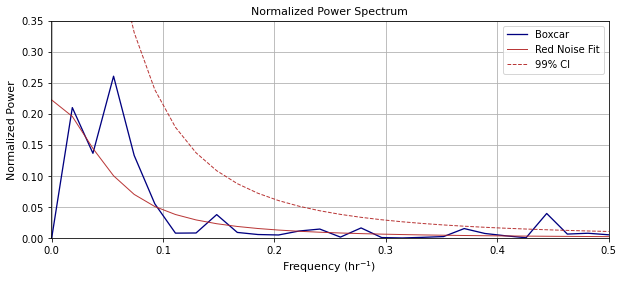

In [8]:
### Plot the results
fig = plt.figure(figsize=(10,4))
method_str = "Boxcar Window on Full Dataset"
plt.plot(freq,ps_n, color='navy', lw=1.3, label='Boxcar')
plt.plot(freq,red_fit_n, color='firebrick', lw=1, alpha=0.9, label='Red Noise Fit') # freq plots 0...0.5
plt.plot(freq,f_bounds, color='firebrick', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI')
plt.ylim(0.0,0.35)
plt.xlim(-0.001,0.5)
plt.xlabel("Frequency (hr$^{-1}$)",fontsize=11)
plt.ylabel("Normalized Power",fontsize=11)
plt.title("Normalized Power Spectrum",fontsize=11)
plt.legend(loc='upper right',fontsize=10)
plt.grid()

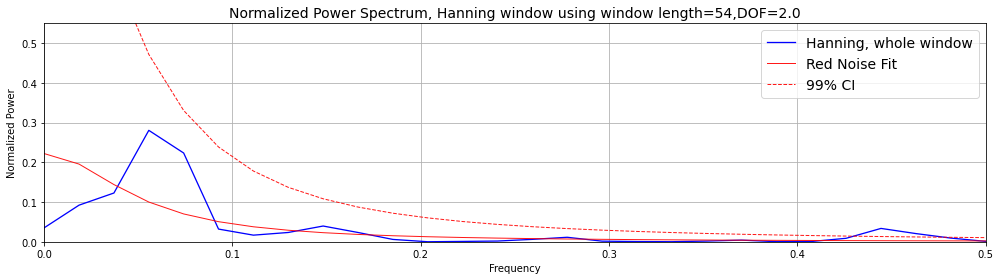

In [12]:
## Use the Hanning Window AND change the length of the data window AND use WOSA (Welch’s Overlapping Segment Analysis)
window_length=len(data) 
T2 = window_length/2
freq_w = np.arange(0.,T2+1.)/window_length
P_welch = signal.welch(data,window='hanning',nperseg=window_length);
P_welch_n = P_welch[1]/np.sum(P_welch[1])  #normalize


## Construct the expected rednoise spectrum - functions
## Need to update the 99% confidence interval
alpha = 0.99
red_fit_n_welch = create_normalized_redfit(window_length,Te)  ## generate red_fit_n using window_length
dof_welch=len(data)/(window_length/2)  ### Barnes Eq. 26
f_bounds_welch= create_f_bounds(alpha,dof_welch,red_fit_n_welch)  ## f-test for variance; 


## plot
fig = plt.figure(figsize=(14,4))
plt.xlabel('Frequency')
plt.ylabel('Normalized Power')
plt.ylim(0.0,0.55)
plt.xlim(0.0,0.5)
plt.grid()
plt.plot(freq_w,P_welch_n, color='blue', lw=1.3, label='Hanning, whole window');
plt.plot(freq_w,red_fit_n_welch, color='red', lw=1, alpha=0.9, label='Red Noise Fit');
plt.plot(freq_w,f_bounds_welch, color='red', lw=1, ls='--', alpha=0.9, label=str(int(alpha*100))+'% CI');
plt.title("Normalized Power Spectrum, Hanning window using window length="+str(window_length)+",DOF="+str(round(dof_welch,0)),fontsize=14);
plt.legend(loc='upper right',fontsize=14)
fig.tight_layout()

In [10]:
for i in range(len(P_welch_n)):
    if (P_welch_n[i]- f_bounds_welch[i]) > 1e-03:  
        
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',P_welch_n-f_bounds_welch[i])
        print('at frequency....',freq[i])
        print('which in hours is...',(1/freq[i]))
        print('    ')
        print('    ')

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... [ 0.02203801  0.07906076  0.10963147  0.26741258  0.21031933  0.01878249
  0.00349164  0.01021862  0.02647157  0.0102125  -0.00725995 -0.01309724
 -0.01228511 -0.01133679 -0.00712376 -0.00184376 -0.01161834 -0.01261158
 -0.01303292 -0.01142169 -0.00907348 -0.0129342  -0.0125399  -0.00442691
  0.02044058  0.00744844 -0.00388953 -0.01214114]
at frequency.... 0.4444444444444444
which in hours is... 2.25
    
    
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... [ 0.02306498  0.08008773  0.11065844  0.26843955  0.2113463   0.01980946
  0.00451861  0.01124559  0.02749854  0.01123947 -0.00623298 -0.01207027
 -0.01125814 -0.01030982 -0.00609679 -0.00081679 -0.01059137 -0.01158461
 -0.01200595 -0.01039472 -0.00804651 -0.01190723 -0.01151293 -0.00339994
  0.02146755  0.00847541 -0.00286256 -0.01111417]
at frequency.... 0.4629629629629629
which in hours is... 2.16
    
    


In [11]:
for i in range(len(P_welch_n)):
    if (P_welch_n[i]- red_fit_n_welch[i]) > 1e-03:  
        
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('exceeds by...',P_welch_n-red_fit_n_welch[i])
        print('at frequency....',freq[i])
        print('which in hours is...',(1/freq[i]))
        print('    ')
        print('    ')

##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... [-0.06484292 -0.00782017  0.02275054  0.18053165  0.1234384  -0.06809844
 -0.08338929 -0.07666231 -0.06040935 -0.07666842 -0.09414088 -0.09997816
 -0.09916603 -0.09821772 -0.09400469 -0.08872469 -0.09849926 -0.09949251
 -0.09991385 -0.09830262 -0.09595441 -0.09981513 -0.09942083 -0.09130783
 -0.06644035 -0.07943248 -0.09077046 -0.09902206]
at frequency.... 0.05555555555555555
which in hours is... 18.0
    
    
##### FOUND IT - spectral peak exceeds red noise ####
exceeds by... [-0.03486797  0.02215478  0.05272548  0.21050659  0.15341335 -0.0381235
 -0.05341434 -0.04668737 -0.03043441 -0.04669348 -0.06416593 -0.07000322
 -0.06919109 -0.06824278 -0.06402974 -0.05874975 -0.06852432 -0.06951757
 -0.06993891 -0.06832767 -0.06597947 -0.06984019 -0.06944589 -0.06133289
 -0.03646541 -0.04945754 -0.06079552 -0.06904712]
at frequency.... 0.07407407407407407
which in hours is... 13.5
    
    
##### FOUND IT - spectral peak exce